In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Bỏ qua cảnh báo FutureWarning
warnings.filterwarnings('ignore')

# Đọc dữ liệu
data = pd.read_csv('AirQualityUCI_with_AQI.csv')

# Kết hợp Date và Time thành Datetime
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

In [14]:
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,IAQI_CO(GT),IAQI_NO2(GT),AQI,Air Quality,Datetime
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754,29.545455,103.270270,103.270270,Unhealthy for Sensitive Groups,2004-03-10 18:00:00
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487,22.727273,91.478261,91.478261,Moderate,2004-03-10 19:00:00
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239,25.000000,103.459459,103.459459,Unhealthy for Sensitive Groups,2004-03-10 20:00:00
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713,25.000000,104.972973,104.972973,Unhealthy for Sensitive Groups,2004-03-10 21:00:00
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794,18.181818,103.837838,103.837838,Unhealthy for Sensitive Groups,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824,35.227273,117.800000,117.800000,Unhealthy for Sensitive Groups,2005-04-04 10:00:00
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864,27.272727,115.794595,115.794595,Unhealthy for Sensitive Groups,2005-04-04 11:00:00
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649,27.272727,114.943243,114.943243,Unhealthy for Sensitive Groups,2005-04-04 12:00:00
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866,23.863636,111.348649,111.348649,Unhealthy for Sensitive Groups,2005-04-04 13:00:00


In [28]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

# Tạo các chuỗi cho Transformer
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        seq = data[i:i + seq_len]
        sequences.append(seq)
    return np.array(sequences)

seq_len = 24  # Độ dài chuỗi (24 giờ)
sequences = create_sequences(scaled_data, seq_len)

# Chuyển sang tensor cho PyTorch
sequences = torch.tensor(sequences, dtype=torch.float32)
print(f"Kích thước sequences: {sequences.shape}")  # [n_samples, seq_len, n_features]

Kích thước sequences: torch.Size([9333, 24, 6])


In [30]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.output_fc = nn.Linear(d_model, input_dim)
        
    def forward(self, x):
        x = self.input_fc(x)  # [batch, seq_len, d_model]
        x = self.transformer(x)  # [batch, seq_len, d_model]
        x = self.output_fc(x[:, -1, :])  # Lấy đặc trưng từ bước thời gian cuối cùng
        return x

# Khởi tạo mô hình
input_dim = len(features)  # Số đặc trưng (6)
d_model = 64  # Kích thước mô hình Transformer
n_heads = 4   # Số head trong self-attention
n_layers = 2  # Số lớp Transformer
model = TimeSeriesTransformer(input_dim, d_model, n_heads, n_layers)

# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
sequences = sequences.to(device)

In [31]:
# Hàm mất mát và bộ tối ưu
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
n_epochs = 10
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(sequences[:-1])  # Dự đoán giá trị tiếp theo
    loss = criterion(outputs, sequences[1:, -1, :])  # So sánh với giá trị thực
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 1.1669
Epoch 2/10, Loss: 0.6672
Epoch 3/10, Loss: 0.4100
Epoch 4/10, Loss: 0.3952
Epoch 5/10, Loss: 0.3543
Epoch 6/10, Loss: 0.3044
Epoch 7/10, Loss: 0.2794
Epoch 8/10, Loss: 0.2749
Epoch 9/10, Loss: 0.2748
Epoch 10/10, Loss: 0.2740


In [32]:
model.eval()
with torch.no_grad():
    features_transformed = model(sequences).cpu().numpy()

print(f"Kích thước đặc trưng trích xuất: {features_transformed.shape}")

Kích thước đặc trưng trích xuất: (9333, 6)


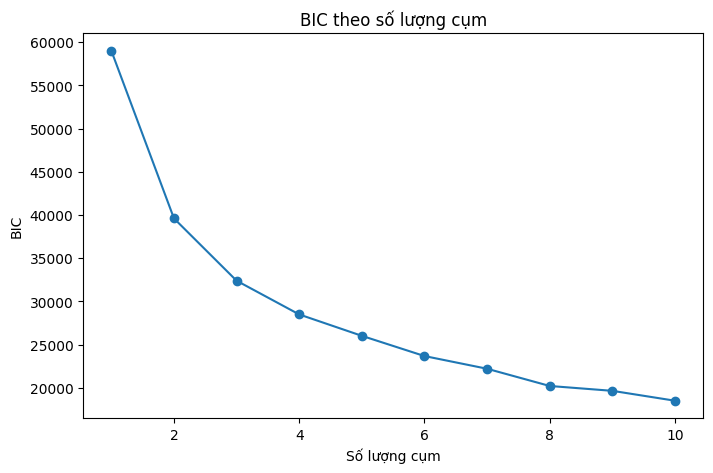

Số cụm tối ưu: 10


In [33]:
# Chọn số cụm tối ưu bằng BIC
n_components_range = range(1, 11)
bics = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(features_transformed)
    bics.append(gmm.bic(features_transformed))

# Vẽ biểu đồ BIC
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bics, marker='o')
plt.xlabel('Số lượng cụm')
plt.ylabel('BIC')
plt.title('BIC theo số lượng cụm')
plt.show()

optimal_n = n_components_range[np.argmin(bics)]
print(f'Số cụm tối ưu: {optimal_n}')

In [34]:
# Áp dụng GMM
gmm = GaussianMixture(n_components=optimal_n, random_state=42)
clusters = gmm.fit_predict(features_transformed)

# Thêm nhãn cụm vào DataFrame (bỏ qua các mẫu cuối do seq_len)
data = data.iloc[seq_len:].reset_index(drop=True)
data['Cluster'] = clusters

# Đánh giá chất lượng phân cụm
if optimal_n > 1:
    score = silhouette_score(features_transformed, clusters)
    print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.1826


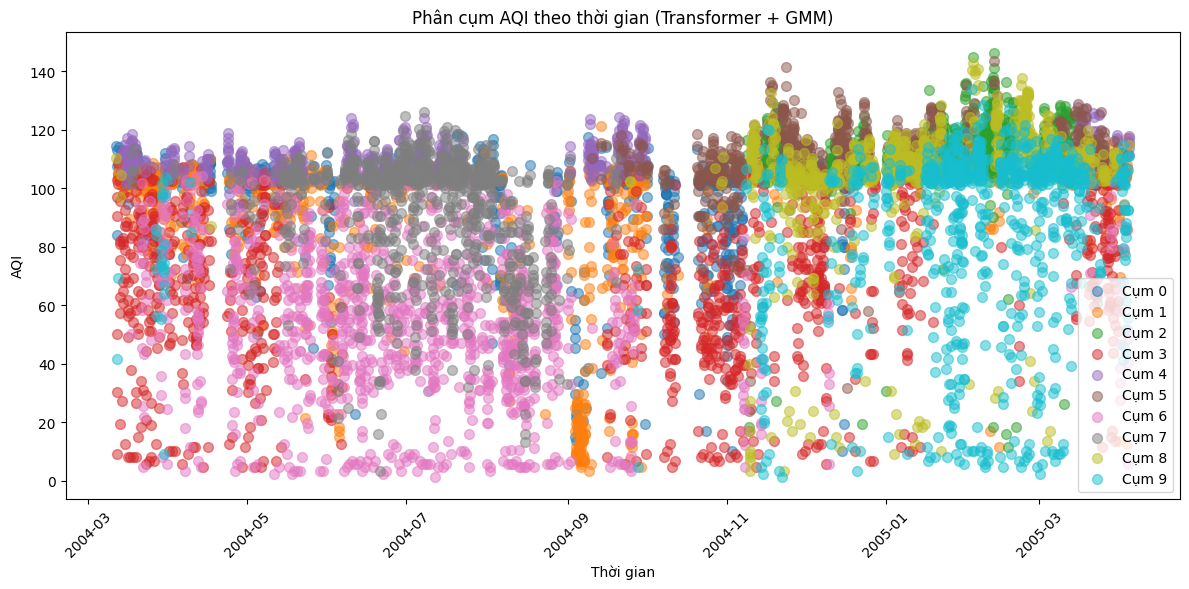

In [35]:
plt.figure(figsize=(12, 6))
for cluster in range(optimal_n):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Datetime'], cluster_data['AQI'], 
                label=f'Cụm {cluster}', alpha=0.5, s=50)
plt.xlabel('Thời gian')
plt.ylabel('AQI')
plt.title('Phân cụm AQI theo thời gian (Transformer + GMM)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

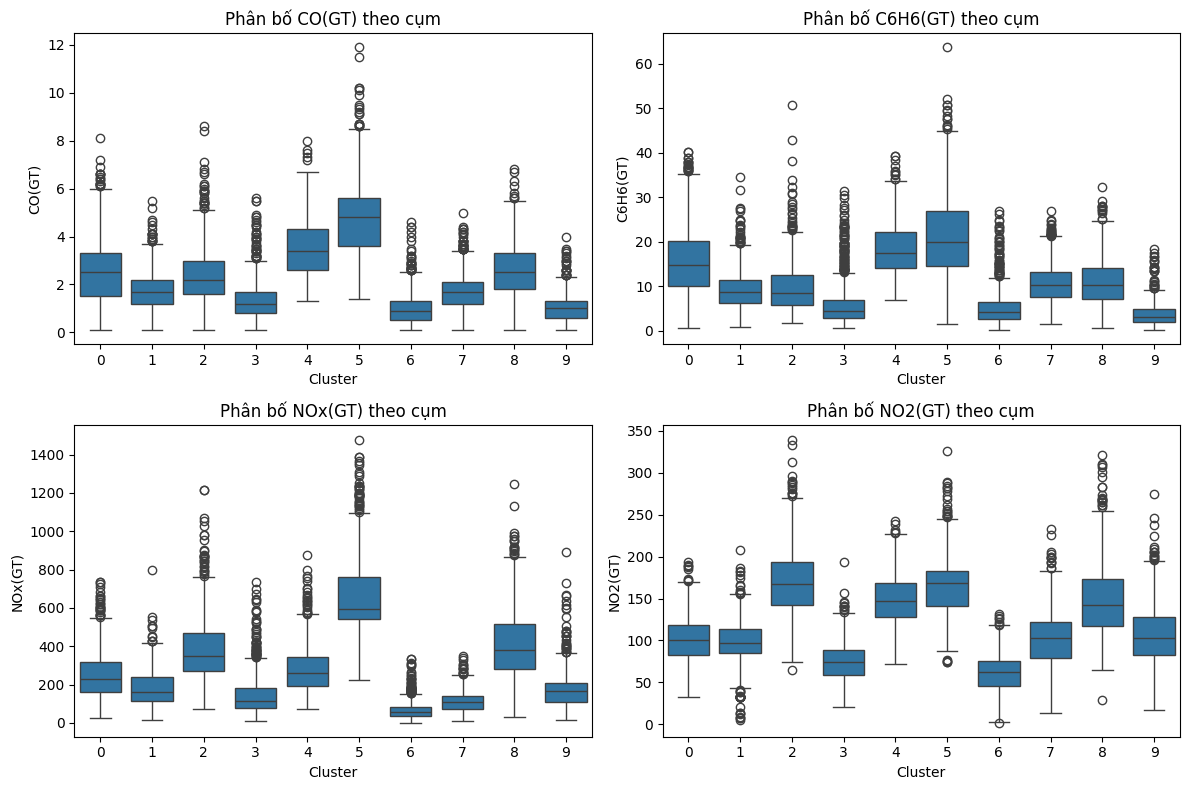

In [36]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features[:4]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f'Phân bố {feature} theo cụm')
plt.tight_layout()
plt.show()

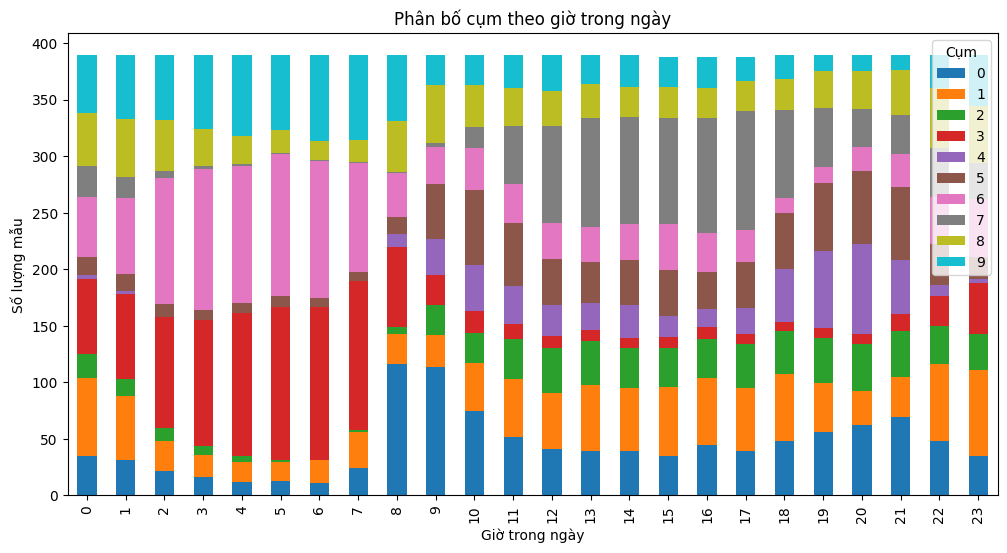

In [37]:
data['Hour'] = data['Datetime'].dt.hour
cluster_by_hour = data.groupby(['Hour', 'Cluster']).size().unstack(fill_value=0)

# Vẽ biểu đồ cột xếp chồng
cluster_by_hour.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bố cụm theo giờ trong ngày')
plt.legend(title='Cụm')
plt.show()

In [38]:
# Tóm tắt đặc trưng
print("Tóm tắt đặc trưng theo cụm:")
print(data.groupby('Cluster')[features + ['AQI']].mean())

# Phân bố chất lượng không khí
print("\nPhân bố chất lượng không khí theo cụm:")
print(data.groupby('Cluster')['Air Quality'].value_counts().unstack(fill_value=0))

Tóm tắt đặc trưng theo cụm:
           CO(GT)   C6H6(GT)     NOx(GT)     NO2(GT)          T         RH  \
Cluster                                                                      
0        2.527391  15.738318  252.845218  101.714020  20.950526  52.485152   
1        1.793774   9.118566  184.781132   97.576887  20.773947  42.355094   
2        2.424172   9.933288  393.519205  170.881457  10.753339  34.782671   
3        1.331387   5.678487  146.252284   75.189594  13.996764  68.278504   
4        3.535397  18.605477  286.986460  150.265571  25.912685  33.202224   
5        4.824749  20.558106  658.233291  165.775126  16.699979  57.550126   
6        0.997524   5.060771   65.924531   61.478170  22.096455  46.069305   
7        1.711741  10.656529  113.067105  102.964575  32.953332  25.285872   
8        2.591981  11.092319  411.266100  148.772783   9.752957  67.122185   
9        1.007030   3.657910  168.430430  105.554774   7.109374  49.880754   

                AQI  
Cluster      